# Install required libraries/packages and import

In [1]:
import boto3
import time
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, current_date,current_timestamp,monotonically_increasing_id,desc,expr,split
from io import StringIO
import pandas as pd
import psycopg2
import os
import numpy as np
import psycopg2.extras as extras

# Connecting to AWS through User Access Key ID and SECRET

In [2]:
#YOUR_ACCESS_KEY_ID, YOUR_SECRET_ACCESS_KEY
s3_resource = boto3.resource('s3',
                      aws_access_key_id='XXXXXXXKREF',
                      aws_secret_access_key='O2EY3a1xD/b+4/DTvYcSBp4l2Dn/dJqo7mBv0a4L')

# Naming the AWS S3 Bucket

In [3]:
def create_bucket_name(bucket_prefix):
    # The generated bucket name must be between 3 and 63 chars long
    current_time_stamp = int(time.time())
    return ''.join([bucket_prefix, str(current_time_stamp)])

# Creating the Bucket

In [4]:
def create_bucket(bucket_prefix, s3_connection):
    bucket_name = create_bucket_name(bucket_prefix)
    bucket_response = s3_resource.create_bucket(Bucket=bucket_name,
                          CreateBucketConfiguration={
                              'LocationConstraint': 'ap-south-1'})
    print(bucket_name, bucket_response)
    return bucket_name, bucket_response

bidnamic_bucket, response = create_bucket(bucket_prefix='bidnamic', s3_connection=s3_resource)

bidnamic1644951344 s3.Bucket(name='bidnamic1644951344')


# Upload Data from Google Ads API (Here using static URL to get data) to AWS S3 Bucket which we have created above

In [5]:
campaigns_df=pd.read_csv('https://raw.githubusercontent.com/bidnamic/bidnamic-data-challenge/master/campaigns.csv')
adgroups_df=pd.read_csv('https://raw.githubusercontent.com/bidnamic/bidnamic-data-challenge/master/adgroups.csv')
search_terms_df=pd.read_csv('https://raw.githubusercontent.com/bidnamic/bidnamic-data-challenge/master/search_terms.csv')

s3_resource.Object(bidnamic_bucket,'campaigns.csv').put(Body=campaigns_df.to_csv(header=True, index=False))
s3_resource.Object(bidnamic_bucket,'adgroups.csv').put(Body=adgroups_df.to_csv(header=True, index=False))
s3_resource.Object(bidnamic_bucket,'search_terms.csv').put(Body=search_terms_df.to_csv(header=True, index=False))

{'ETag': '"ee890ae65319507f400bef5563b7ad50"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Tue, 15 Feb 2022 18:56:17 GMT',
   'etag': '"ee890ae65319507f400bef5563b7ad50"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'y4Rl7XsulcYQfZ5oFDYOEnlgc1OsBRmUs+wTjzHPdXVZqAQOVBbLTBEBipdbm/ymyb2Iw/Tllkk=',
   'x-amz-request-id': '6148DE1WBEFRGCYV'},
  'HTTPStatusCode': 200,
  'HostId': 'y4Rl7XsulcYQfZ5oFDYOEnlgc1OsBRmUs+wTjzHPdXVZqAQOVBbLTBEBipdbm/ymyb2Iw/Tllkk=',
  'RequestId': '6148DE1WBEFRGCYV',
  'RetryAttempts': 0}}

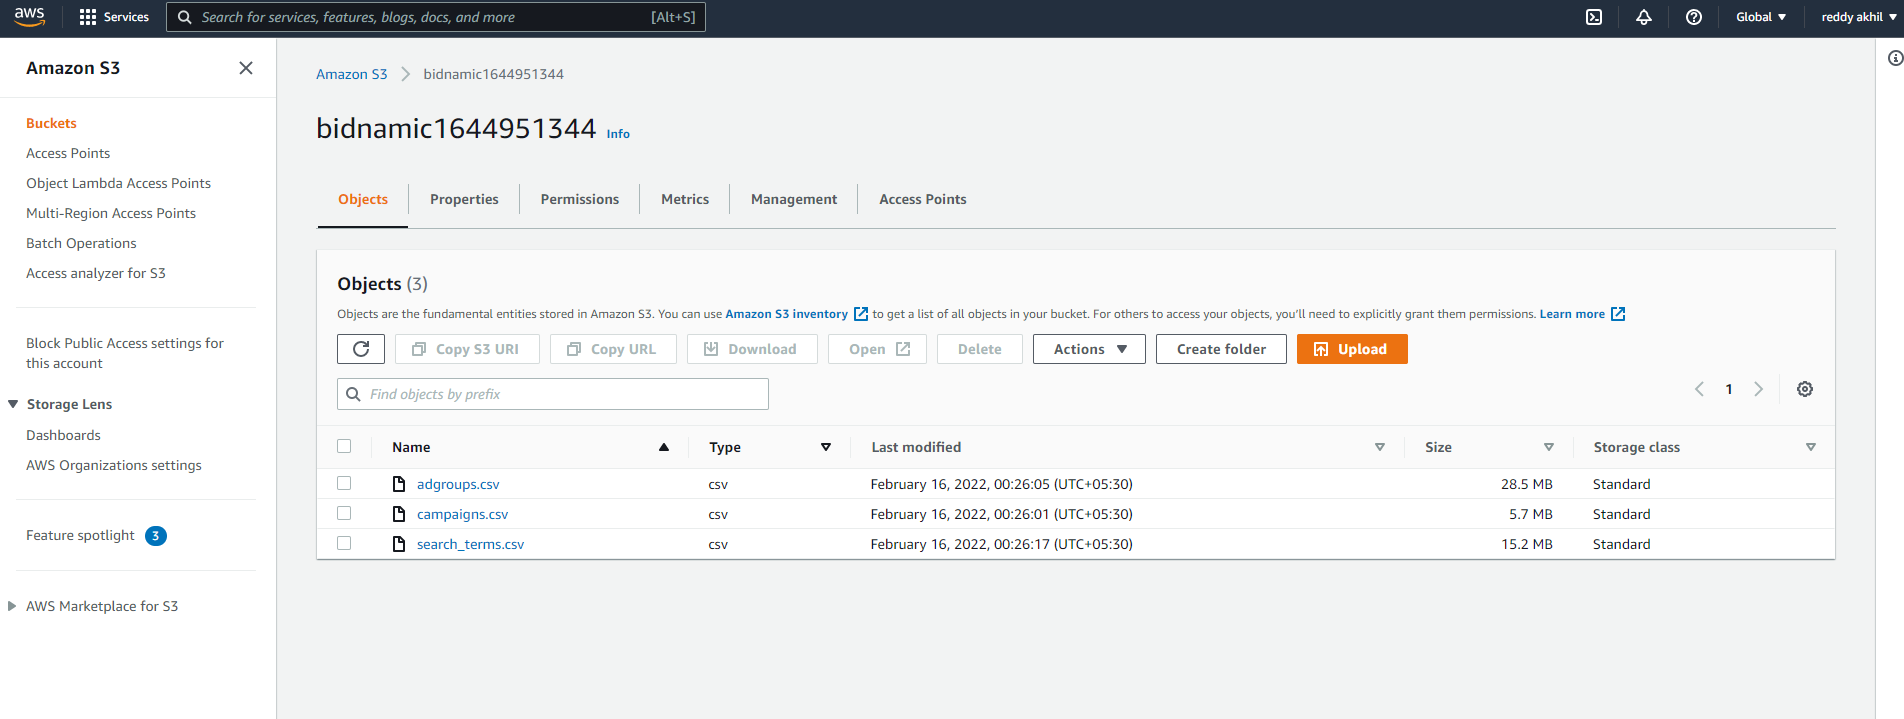

# Fetching data from AWS S3 Bucket

In [6]:
spark=SparkSession.builder.appName('bidnamic-task').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled","true")
bucket = s3_resource.Bucket('bidnamic1644951344')

C:\Users\harsh\Anaconda3\envs\forproject\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [7]:
data={}
for obj in bucket.objects.all():
    data[obj.key]=obj.get()['Body'].read()

# Converting string data to Spark Dataframes using pandas
### also dropping duplicate data

In [8]:
campaigns_s=StringIO(str(data['campaigns.csv'],'utf-8'))
campaigns_pd_df=pd.read_csv(campaigns_s, header=0)
campaigns_df=spark.createDataFrame(campaigns_pd_df)
campaigns_df.printSchema()
print('Total rows before dropping duplicates:', campaigns_df.count())
campaigns_df=campaigns_df.dropDuplicates()
print('Total rows after dropping duplicates:', campaigns_df.count())
campaigns_df.show()

root
 |-- campaign_id: long (nullable = true)
 |-- structure_value: string (nullable = true)
 |-- status: string (nullable = true)

Total rows before dropping duplicates: 221855
Total rows after dropping duplicates: 352
+-----------+---------------+-------+
|campaign_id|structure_value| status|
+-----------+---------------+-------+
| 9814033357|      sure shot|ENABLED|
|11560224153|phoenix fitness|ENABLED|
|15433958782|       o'neills|ENABLED|
| 7097759415|          dukes|ENABLED|
| 1578412454|         wilson|ENABLED|
| 1960581074|           hype|ENABLED|
| 2069163253|     sorbothane|ENABLED|
| 2045066340|          yonex|ENABLED|
| 1578630124|        optimum|ENABLED|
| 9577408222|  urban fitness|ENABLED|
| 1578630379|         reusch|ENABLED|
| 1578451887|          venum|ENABLED|
| 1578629929|    fitness mad|ENABLED|
| 1578412478|          zoggs|ENABLED|
| 1578412487|       zoo york|ENABLED|
| 1736054301|      armadillo|ENABLED|
|10359383651| a&a sports ltd|ENABLED|
| 8532655360|       

In [9]:
search_terms_s=StringIO(str(data['search_terms.csv'],'utf-8'))
search_terms_pd_df=pd.read_csv(search_terms_s, header=0)
search_terms_df=spark.createDataFrame(search_terms_pd_df) 
search_terms_df.printSchema()
print('Total rows before dropping duplicates:', search_terms_df.count())
search_terms_df=search_terms_df.dropDuplicates()
print('Total rows after dropping duplicates:', search_terms_df.count())
search_terms_df.show()

root
 |-- date: string (nullable = true)
 |-- ad_group_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- clicks: long (nullable = true)
 |-- cost: double (nullable = true)
 |-- conversion_value: double (nullable = true)
 |-- conversions: long (nullable = true)
 |-- search_term: string (nullable = true)

Total rows before dropping duplicates: 221855
Total rows after dropping duplicates: 221673
+----------+------------+-----------+------+----+----------------+-----------+--------------------+
|      date| ad_group_id|campaign_id|clicks|cost|conversion_value|conversions|         search_term|
+----------+------------+-----------+------+----+----------------+-----------+--------------------+
|2021-12-22|119487451918| 1578411800|     1|0.07|             0.0|          0|     little nike bag|
|2020-12-27|121875999824| 1578451560|     1|0.01|             0.0|          0|crep protect crea...|
|2020-12-22|121875999824| 1578451560|     1|0.09|             0.0|          0|dec

In [10]:
adgroups_s=StringIO(str(data['adgroups.csv'],'utf-8'))
adgroups_pd_df=pd.read_csv(adgroups_s, header=0)
adgroups_df=spark.createDataFrame(adgroups_pd_df)
adgroups_df.printSchema()
print('Total rows before dropping duplicates:', adgroups_df.count())
adgroups_df=adgroups_df.dropDuplicates()
print('Total rows after dropping duplicates:', adgroups_df.count())
adgroups_df.show()

root
 |-- ad_group_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- alias: string (nullable = true)
 |-- status: string (nullable = true)

Total rows before dropping duplicates: 221855
Total rows after dropping duplicates: 19271
+------------+-----------+--------------------+-------+
| ad_group_id|campaign_id|               alias| status|
+------------+-----------+--------------------+-------+
| 61228309826| 1578411800|Shift - Shopping ...|REMOVED|
| 57055476462| 1578451347|Shift - Shopping ...|REMOVED|
| 63648768190| 1578411800|Shift - Shopping ...|REMOVED|
| 58759160599| 1578629887|Shift - Shopping ...|REMOVED|
|106801806696| 1578629887|Shift - Shopping ...|ENABLED|
| 62237939694| 1578629887|Shift - Shopping ...|ENABLED|
| 64990779729| 1578451584|Shift - Shopping ...|REMOVED|
|104151392391| 1578411800|Shift - Shopping ...|ENABLED|
| 60702493598| 1578412481|Shift - Shopping ...|REMOVED|
|104277714862| 1578629887|Shift - Shopping ...|ENABLED|
| 64369657875| 1578

# Splitting adgroup alias to individual columns using given format:

<h4> Shift - Shopping - [country] - [campaign structure value] - [priority] - [random string] - [hash] </h4>

In [11]:
adgroups_df = adgroups_df.withColumn("country", split(col("alias"), " - ").getItem(2))\
    .withColumn("priority", split(col("alias"), " - ").getItem(4)).drop('alias')
adgroups_df.printSchema()
adgroups_df.show()
print('Total rows: ',adgroups_df.count())

root
 |-- ad_group_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- status: string (nullable = true)
 |-- country: string (nullable = true)
 |-- priority: string (nullable = true)

+------------+-----------+-------+-------+--------+
| ad_group_id|campaign_id| status|country|priority|
+------------+-----------+-------+-------+--------+
| 61228309826| 1578411800|REMOVED|     GB|    HIGH|
| 57055476462| 1578451347|REMOVED|     GB|  MEDIUM|
| 63648768190| 1578411800|REMOVED|     GB|    HIGH|
| 58759160599| 1578629887|REMOVED|     GB|    HIGH|
|106801806696| 1578629887|ENABLED|     GB|    HIGH|
| 62237939694| 1578629887|ENABLED|     GB|    HIGH|
| 64990779729| 1578451584|REMOVED|     GB|    HIGH|
|104151392391| 1578411800|ENABLED|     GB|    HIGH|
| 60702493598| 1578412481|REMOVED|     GB|     LOW|
|104277714862| 1578629887|ENABLED|     GB|    HIGH|
| 64369657875| 1578630121|REMOVED|     GB|     LOW|
| 70187762536| 1578629887|ENABLED|     GB|    HIGH|
| 59899063176| 

# Joining the adgroups dataframe with search_terms dataframe

In [12]:
master_df = adgroups_df.join(search_terms_df, adgroups_df.ad_group_id == search_terms_df.ad_group_id).select(adgroups_df.ad_group_id,
                    adgroups_df.campaign_id,
                    adgroups_df.country,
                    adgroups_df.priority,
                    adgroups_df.status,
                    search_terms_df.conversion_value,
                    search_terms_df.cost,
                    search_terms_df.date,
                    search_terms_df.search_term)
                    
master_df.printSchema()
master_df.show()
print('Total rows in master dataframe: ',master_df.count())

root
 |-- ad_group_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- country: string (nullable = true)
 |-- priority: string (nullable = true)
 |-- status: string (nullable = true)
 |-- conversion_value: double (nullable = true)
 |-- cost: double (nullable = true)
 |-- date: string (nullable = true)
 |-- search_term: string (nullable = true)

+------------+-----------+-------+--------+-------+----------------+----+----------+--------------------+
| ad_group_id|campaign_id|country|priority| status|conversion_value|cost|      date|         search_term|
+------------+-----------+-------+--------+-------+----------------+----+----------+--------------------+
|119487451918| 1578411800|     GB|    HIGH|ENABLED|             0.0|0.07|2021-12-22|     little nike bag|
|121875999824| 1578451560|     GB|    HIGH|ENABLED|             0.0|0.01|2020-12-27|crep protect crea...|
|121875999824| 1578451560|     GB|    HIGH|ENABLED|             0.0|0.09|2020-12-22|decreasers foot l.

# Calculating ROAS

In [13]:
final_df = master_df.select(master_df.date,
                    master_df.ad_group_id,
                    master_df.campaign_id,
                    master_df.country,
                    master_df.priority,
                    (master_df.conversion_value/master_df.cost).alias('ROAS'),
                    master_df.status,
                    master_df.search_term)
final_df = final_df.sort(col("ROAS").desc())
final_df.printSchema()
final_df.show()
print('Total rows in final dataframe: ',final_df.count())

root
 |-- date: string (nullable = true)
 |-- ad_group_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- country: string (nullable = true)
 |-- priority: string (nullable = true)
 |-- ROAS: double (nullable = true)
 |-- status: string (nullable = true)
 |-- search_term: string (nullable = true)

+----------+------------+-----------+-------+--------+-----------------+-------+--------------------+
|      date| ad_group_id|campaign_id|country|priority|             ROAS| status|         search_term|
+----------+------------+-----------+-------+--------+-----------------+-------+--------------------+
|2020-04-19| 89733540649| 8677963439|     GB|    HIGH|          21149.0|REMOVED|net1 basketball h...|
|2020-07-02| 96088579090| 1578411797|     GB|  MEDIUM|          10594.0|ENABLED|     nike kawa slide|
|2018-12-11| 62503127714| 1578629887|     GB|    HIGH|          10298.0|ENABLED|womens weightlift...|
|2019-04-23| 62679062867| 1578629887|     GB|    HIGH|          1029

# Load the Final Dataframe into PostgreSQL Table which is present in AWS

In [86]:
engine = psycopg2.connect(
    database="bidnamic",
    user="akhil",
    password="password",
    host="bidnamic-postgresql-task.xxxxxx.ap-south-1.rds.amazonaws.com",
    port='5432'
)

engine.autocommit = True

## Create Table in PostgreSQL with name as final_table

In [87]:
cursor = engine.cursor()
cursor.execute("""CREATE TABLE final_table (date DATE, ad_group_id int8 NOT NULL, campaign_id int8, country VARCHAR(10),
priority VARCHAR(20), ROAS float8, status VARCHAR(20), search_term VARCHAR(100))""")
cursor.close()

## Insert Values into final_table from Pyspark DataFrame final_df

In [88]:
def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()

In [89]:
execute_values(engine, final_df.toPandas(), 'final_table')

execute_values() done


## Fetching the table records based on Aggregation Columns (Country and/or priority)

In [90]:
cursor = engine.cursor()
cursor.execute("""SELECT * FROM final_table LIMIT 5""")
all_records = cursor.fetchall()
for row in all_records:
    print("date = ", row[0])
    print("ad_group_id = ", row[1])
    print("campaign_id  = ", row[2])
    print("country = ", row[3])
    print("priority = ", row[4])
    print("ROAS = ", row[5])
    print("status = ", row[6])
    print("search_term = ", row[7], "\n")
cursor.close()

date =  2020-04-19
ad_group_id =  89733540649
campaign_id  =  8677963439
country =  GB
priority =  HIGH
ROAS =  21149.0
status =  REMOVED
search_term =  net1 basketball hoop millennium 

date =  2020-07-02
ad_group_id =  96088579090
campaign_id  =  1578411797
country =  GB
priority =  MEDIUM
ROAS =  10594.0
status =  ENABLED
search_term =  nike kawa slide 

date =  2018-12-11
ad_group_id =  62503127714
campaign_id  =  1578629887
country =  GB
priority =  HIGH
ROAS =  10298.0
status =  ENABLED
search_term =  womens weightlifting shoes uk 

date =  2019-04-23
ad_group_id =  62679062867
campaign_id  =  1578629887
country =  GB
priority =  HIGH
ROAS =  10298.0
status =  REMOVED
search_term =  adidas adizero adios japan 

date =  2018-12-09
ad_group_id =  62501633754
campaign_id  =  1578411800
country =  GB
priority =  HIGH
ROAS =  9395.0
status =  REMOVED
search_term =  asics compression shorts mens 



In [96]:
cursor = engine.cursor()
cursor.execute("""SELECT country, priority, avg(nullif(roas, 'NaN')) FROM final_table WHERE roas>0.0 GROUP BY country,priority""")
all_records = cursor.fetchall()
for row in all_records:
    print("country = ", row[0])
    print("priority = ", row[1])
    print("Average ROAS = ", row[2], "\n")
cursor.close()

country =  GB
priority =  HIGH
Average ROAS =  660.218803813373 

country =  GB
priority =  LOW
Average ROAS =  223.546886140003 

country =  GB
priority =  MEDIUM
Average ROAS =  359.031619859308 



## To Drop the table from PostgreSQL database

In [97]:
cursor = engine.cursor()
cursor.execute("""DROP TABLE final_table""")
cursor.close()

In [98]:
engine.close()

# Thank You
### Author: Akhil Reddy Narala